In [1]:
%pip install scikit-learn
%pip install scikit-image
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from collections import Counter

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [ ]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.resize(img, (500, 300))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

## Data Understanding

In [4]:
# Jumlah Data
print("Jumlah total gambar:", len(data))
print("Jumlah kelas:", len(np.unique(labels)))
print("Distribusi per kelas:", Counter(labels))

Jumlah total gambar: 223
Jumlah kelas: 2
Distribusi per kelas: Counter({np.str_('Healthy Teeth'): 116, np.str_('Impacted teeth'): 107})


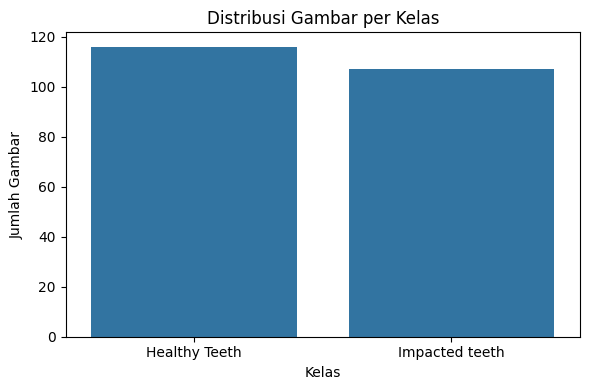

In [5]:
# Distribusi Data
label_df = pd.DataFrame({'Label': labels})
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=label_df)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

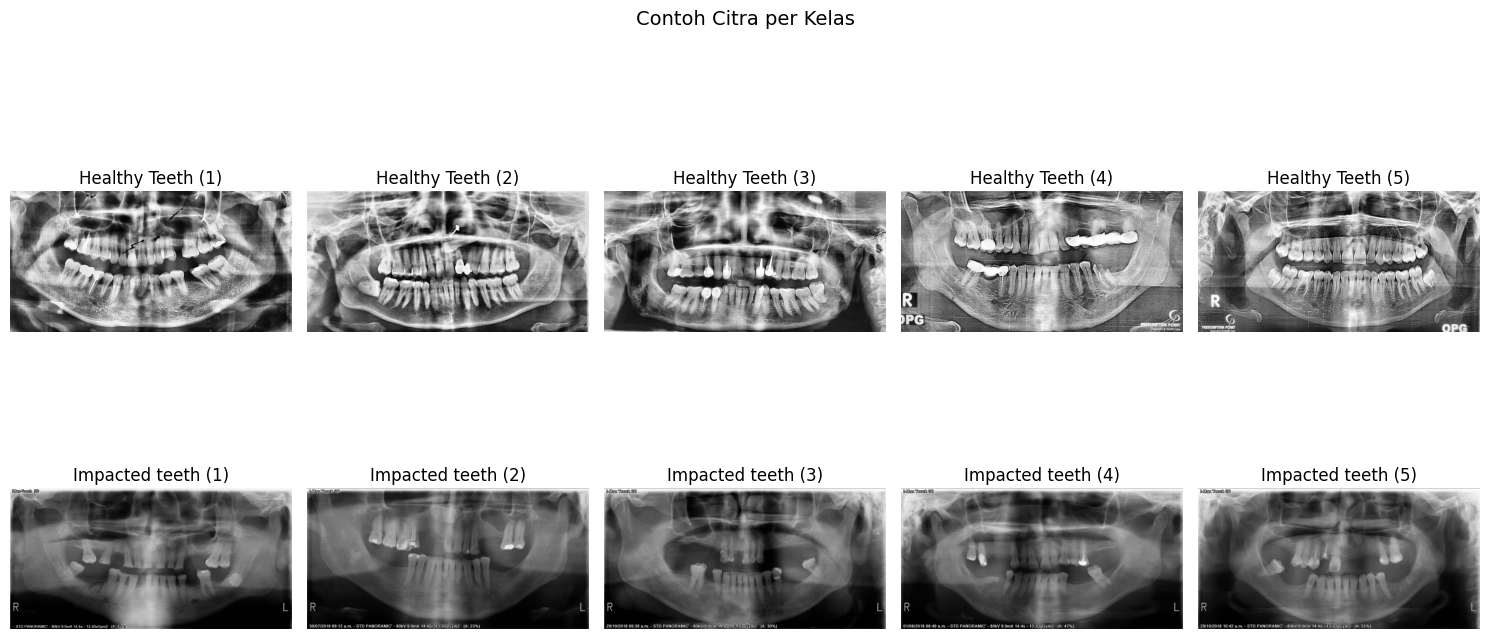

In [6]:
#Sample Gambar per Kelas
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 8))  # disesuaikan agar muat 5 kolom

for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 indeks pertama untuk label ini
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i*5 + j + 1)
        plt.imshow(data[idx], cmap='gray')
        plt.title(f"{label} ({j+1})")
        plt.axis('off')

plt.suptitle("Contoh Citra per Kelas", fontsize=14)
plt.tight_layout()
plt.show()

## Data Augmentation

### Define Augmentation Function


In [ ]:
# # Inisialisasi
# data_augmented = []
# labels_augmented = []
# paths_augmented = []
# file_name_augmented = []

# # Target label
# target_label = "Impacted teeth"
# augment_limit = 10
# count = 0

# for i in range(len(data)):
#     if labels[i] == target_label and count < augment_limit:
#         original = data[i]
#         label = labels[i]
#         fname = file_name[i]

#         # Augmentasi: flip horizontal
#         flipped = cv.flip(original, 1) # ganti

#         # Augmentasi: rotasi 15 derajat
#         (h, w) = original.shape[:2]
#         center = (w // 2, h // 2)
#         M = cv.getRotationMatrix2D(center, 15, 1.0)  # ganti
#         rotated = cv.warpAffine(original, M, (w, h)) # ganti 

#         # Augmentasi: crop bagian tengah
#         cropped = original[50:h-50, 50:w-50]
#         cropped = cv.resize(cropped, (w, h)) # ganti

#         # Tambahkan hasil augmentasi
#         for aug, suffix in zip([flipped, rotated, cropped], ['_flip', '_rot', '_crop']):
#             data_augmented.append(aug)
#             labels_augmented.append(label)
#             file_name_augmented.append(fname + suffix)
#             paths_augmented.append("aug_" + fname + suffix)

#         count += 1

# print(f"Augmentasi selesai untuk label '{target_label}' sebanyak {count} gambar.")


Augmentasi selesai untuk label 'Impacted teeth' sebanyak 10 gambar.


In [ ]:
# print("Data sebelum augmentasi: ", len(data))
# data = np.concatenate([data, np.array(data_augmented)])
# labels = np.concatenate([labels, np.array(labels_augmented)])
# file_name = np.concatenate([file_name, np.array(file_name_augmented)])
# print("Data setelah augmentasi: ", len(data))

Data sebelum augmentasi:  223
Data setelah augmentasi:  253


Jumlah gambar per kelas:
Label
Impacted teeth    137
Healthy Teeth     116
Name: count, dtype: int64


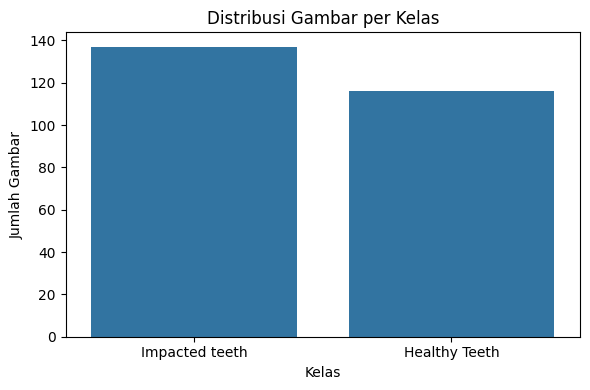

In [9]:
# Membuat DataFrame dari labels
label_df = pd.DataFrame({'Label': labels})

# Hitung jumlah gambar per kelas
label_counts = label_df['Label'].value_counts()

# Tampilkan count-nya
print("Jumlah gambar per kelas:")
print(label_counts)

# Visualisasi
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=label_df, order=label_counts.index)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()


## Data Preparation

### Define Preprocessing Function


In [10]:
Sx = np.array([ [-1,0,1],
                [-2,0,2],
                [-1,0,1]])

Sy = np.array([ [1,2,1],
                [0,0,0],
                [-1,-2,-1]])

Px = np.array([ [-1,0,1],
                [-1,0,1],
                [-1,0,1]])

Py = np.array([ [1,1,1],
                [0,0,0],
                [-1,-1,-1]])

Rt = np.array([ [1,0],
                [0,-1]])

Rk = np.array([ [0,1],
                [-1,0]])

In [11]:
def padding_baris(image):
    height, width = image.shape
    img_pad = np.zeros((height, width+1))
    for i in range(height):
        for j in range(width):
            img_pad[i][j] = image[i][j]
    return img_pad

def padding_kolom(image):
    height, width = image.shape
    img_pad = np.zeros((height+1, width))
    for i in range(height):
        for j in range(width):
            img_pad[i][j] = image[i][j]
    return img_pad

def convo_edge(image, kernel, jenis):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    if(jenis!="roberts"):
        padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    else:
        padded_baris = padding_baris(image)
        padded_img = padding_kolom(padded_baris)
    result = np.zeros([img_height, img_width])

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result

def deteksi_tepi(image, kernelX, kernelY, jenis):
    hasilX = convo_edge(image, kernelX, jenis)
    hasilY = convo_edge(image, kernelY, jenis)

    hasil = np.sqrt((hasilX*hasilX)+(hasilY*hasilY))

    return hasil

def thresholding(image, batas):
    hasil = np.copy(image)
    hasil[hasil>=batas] = 255
    hasil[hasil<batas] = 0

    for i in range(hasil.shape[0]):
        for j in range(hasil.shape[1]):
            if(hasil[i][j]==0):
                hasil[i][j]=0
            else:
                hasil[i][j]=255
    return hasil

def thresholding2(image, T):
    result = np.zeros_like(image)
    result[image <= T] = 1
    return result

In [12]:
kernel = np.array([[0, 0, 1, 1, 1],
                   [0, 0, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 0, 0],
                   [1, 1, 1, 0, 0]], dtype=np.uint8)

def dilasi(img, kernel):
    img = img.copy()
    pad_h, pad_w = kernel.shape[0] // 2, kernel.shape[1] // 2
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            if np.any(region[kernel == 1] == 255):
                output[i, j] = 255
    return output


def erosi(img, kernel):
    img = img.copy()
    pad_h, pad_w = kernel.shape[0] // 2, kernel.shape[1] // 2
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            if np.all(region[kernel == 1] == 255):
                output[i, j] = 255
    return output

def opening(img, kernel):
    return dilasi(erosi(img, kernel), kernel)

def closing(img, kernel):
    return erosi(dilasi(img, kernel), kernel)

def morph_gradient(dilasi_result, erosi_result):
    Gradient_Morph = dilasi_result - erosi_result
    return Gradient_Morph

### Coba Preprocessing

In [13]:
# sobel = deteksi_tepi(data[3], Sx, Sy, "sobel")
# prewitt = deteksi_tepi(data[3], Px, Py, "prewitt")
# thresh = thresholding(data[3], 140)

In [14]:
# plt.figure(figsize=(10,10))

# plt.subplot(2,2,1)
# plt.imshow(data[3], cmap='gray')
# plt.title(labels[3] )

# plt.subplot(2,2,2)
# plt.imshow(sobel, cmap='gray')
# plt.title('Sobel')

# plt.subplot(2,2,3)
# plt.imshow(prewitt, cmap='gray')
# plt.title('Prewitt')

# plt.subplot(2,2,4)
# plt.imshow(thresh, cmap='gray')
# plt.title('Thresholding')

# plt.tight_layout()
# plt.show()

In [15]:
# thresh = thresholding2(prewitt, 2)
# plt.imshow(thresh, cmap='gray')

In [16]:
# plt.figure(figsize=(10,10))

# plt.subplot(2,1,1)
# plt.imshow(data[200], cmap='gray')
# plt.title(labels[200] )


# plt.subplot(2,1,2)
# thresh = opening(prewitt, kernel)
# plt.imshow(thresh, cmap='gray')
# plt.title('opening')



In [17]:
# img_dilasi = dilasi(thresh, kernel)
# img_erosi = erosi(thresh, kernel)
# img_closing = closing(thresh, kernel)
# img_opening = opening(thresh, kernel)
# img_gradient = morph_gradient(img_dilasi, img_erosi)
    

In [18]:
# titles = ['Original', 'Dilasi', 'Erosi', 'Closing', 'Opening', 'Gradient']
# images = [thresh, img_dilasi, img_erosi, img_closing, img_opening, img_gradient ]


# plt.figure(figsize=(18, 10))
# for i in range(len(images)):
#     plt.subplot(3, 2, i+1)
#     plt.imshow(images[i], cmap='gray')
#     plt.title(titles[i])
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

### Preprocessing

In [19]:
dataPreprocessed = [] 
for i in range(len(data)): 
	img = data[i] 
	thresh = thresholding(data[3], 140)
	img = opening(thresh, kernel)

	dataPreprocessed.append(img) 	

dataPreprocessed = np.array(dataPreprocessed) 

### Menampilkan Sample Gambar hasil preprosesing per Kelas


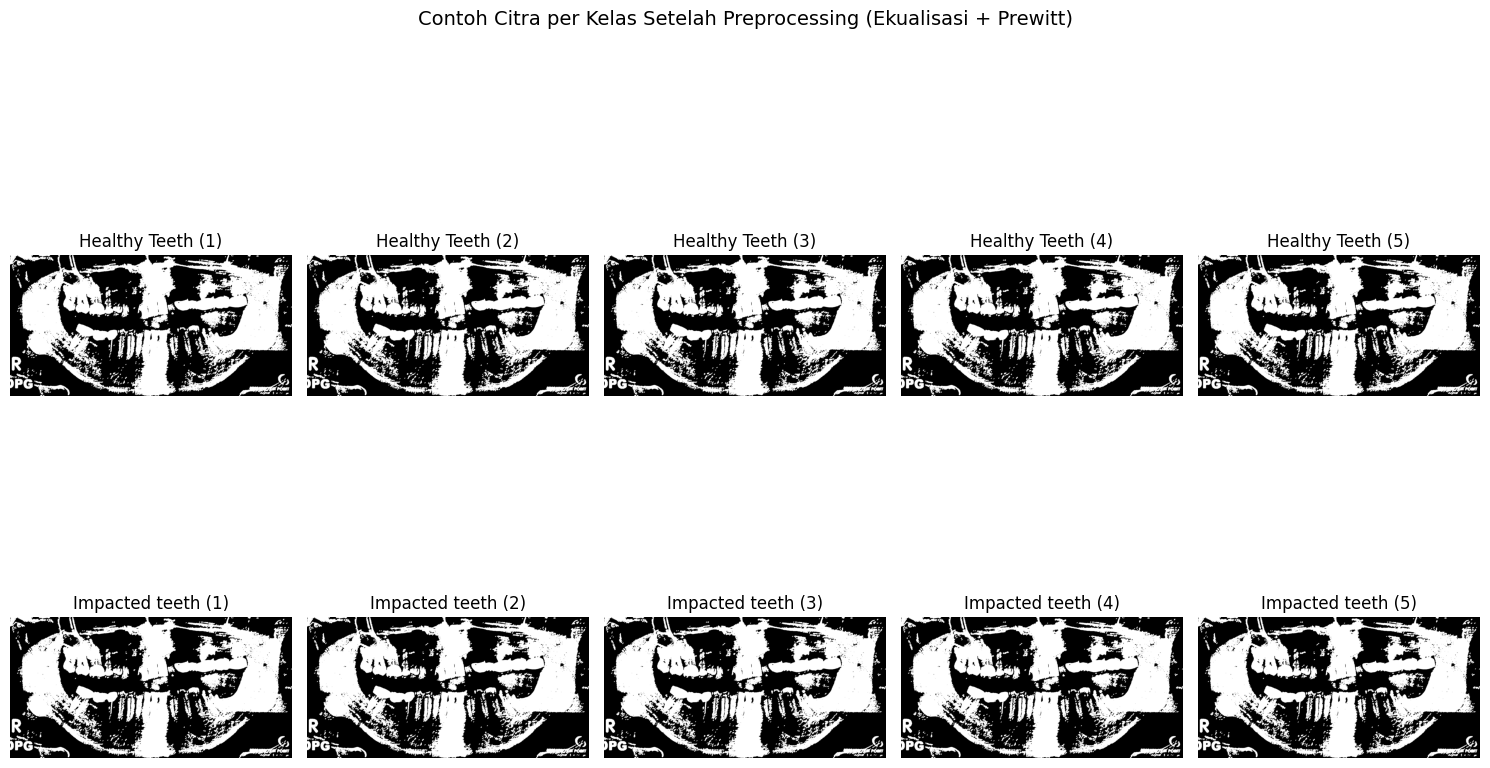

In [20]:
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 10))  # disesuaikan agar muat 5 kolom

for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 indeks pertama untuk label ini
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i*5 + j + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.title(f"{label} ({j+1})")
        plt.axis('off')

plt.suptitle("Contoh Citra per Kelas Setelah Preprocessing (Ekualisasi + Prewitt)", fontsize=14)
plt.tight_layout()
plt.show()

### Feature Extraction

In [21]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [22]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [23]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [24]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [25]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [26]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [27]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [28]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [29]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [30]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [31]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [32]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [33]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [34]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [35]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [36]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [37]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [38]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1.jpg,Healthy Teeth,1937.802104,3191.335166,2045.237584,2812.316738,0.9702,0.950922,0.968547,0.956751,...,0.474827,0.463854,0.690237,0.677173,0.689077,0.681068,0.939755,0.900805,0.936421,0.912586
1,10.jpg,Healthy Teeth,1937.802104,3191.335166,2045.237584,2812.316738,0.9702,0.950922,0.968547,0.956751,...,0.474827,0.463854,0.690237,0.677173,0.689077,0.681068,0.939755,0.900805,0.936421,0.912586
2,100.jpg,Healthy Teeth,1937.802104,3191.335166,2045.237584,2812.316738,0.9702,0.950922,0.968547,0.956751,...,0.474827,0.463854,0.690237,0.677173,0.689077,0.681068,0.939755,0.900805,0.936421,0.912586
3,101.jpg,Healthy Teeth,1937.802104,3191.335166,2045.237584,2812.316738,0.9702,0.950922,0.968547,0.956751,...,0.474827,0.463854,0.690237,0.677173,0.689077,0.681068,0.939755,0.900805,0.936421,0.912586
4,102.jpg,Healthy Teeth,1937.802104,3191.335166,2045.237584,2812.316738,0.9702,0.950922,0.968547,0.956751,...,0.474827,0.463854,0.690237,0.677173,0.689077,0.681068,0.939755,0.900805,0.936421,0.912586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,11.jpg_rot,Impacted teeth,1937.802104,3191.335166,2045.237584,2812.316738,0.9702,0.950922,0.968547,0.956751,...,0.474827,0.463854,0.690237,0.677173,0.689077,0.681068,0.939755,0.900805,0.936421,0.912586
249,11.jpg_crop,Impacted teeth,1937.802104,3191.335166,2045.237584,2812.316738,0.9702,0.950922,0.968547,0.956751,...,0.474827,0.463854,0.690237,0.677173,0.689077,0.681068,0.939755,0.900805,0.936421,0.912586
250,116.jpg_flip,Impacted teeth,1937.802104,3191.335166,2045.237584,2812.316738,0.9702,0.950922,0.968547,0.956751,...,0.474827,0.463854,0.690237,0.677173,0.689077,0.681068,0.939755,0.900805,0.936421,0.912586
251,116.jpg_rot,Impacted teeth,1937.802104,3191.335166,2045.237584,2812.316738,0.9702,0.950922,0.968547,0.956751,...,0.474827,0.463854,0.690237,0.677173,0.689077,0.681068,0.939755,0.900805,0.936421,0.912586


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: >

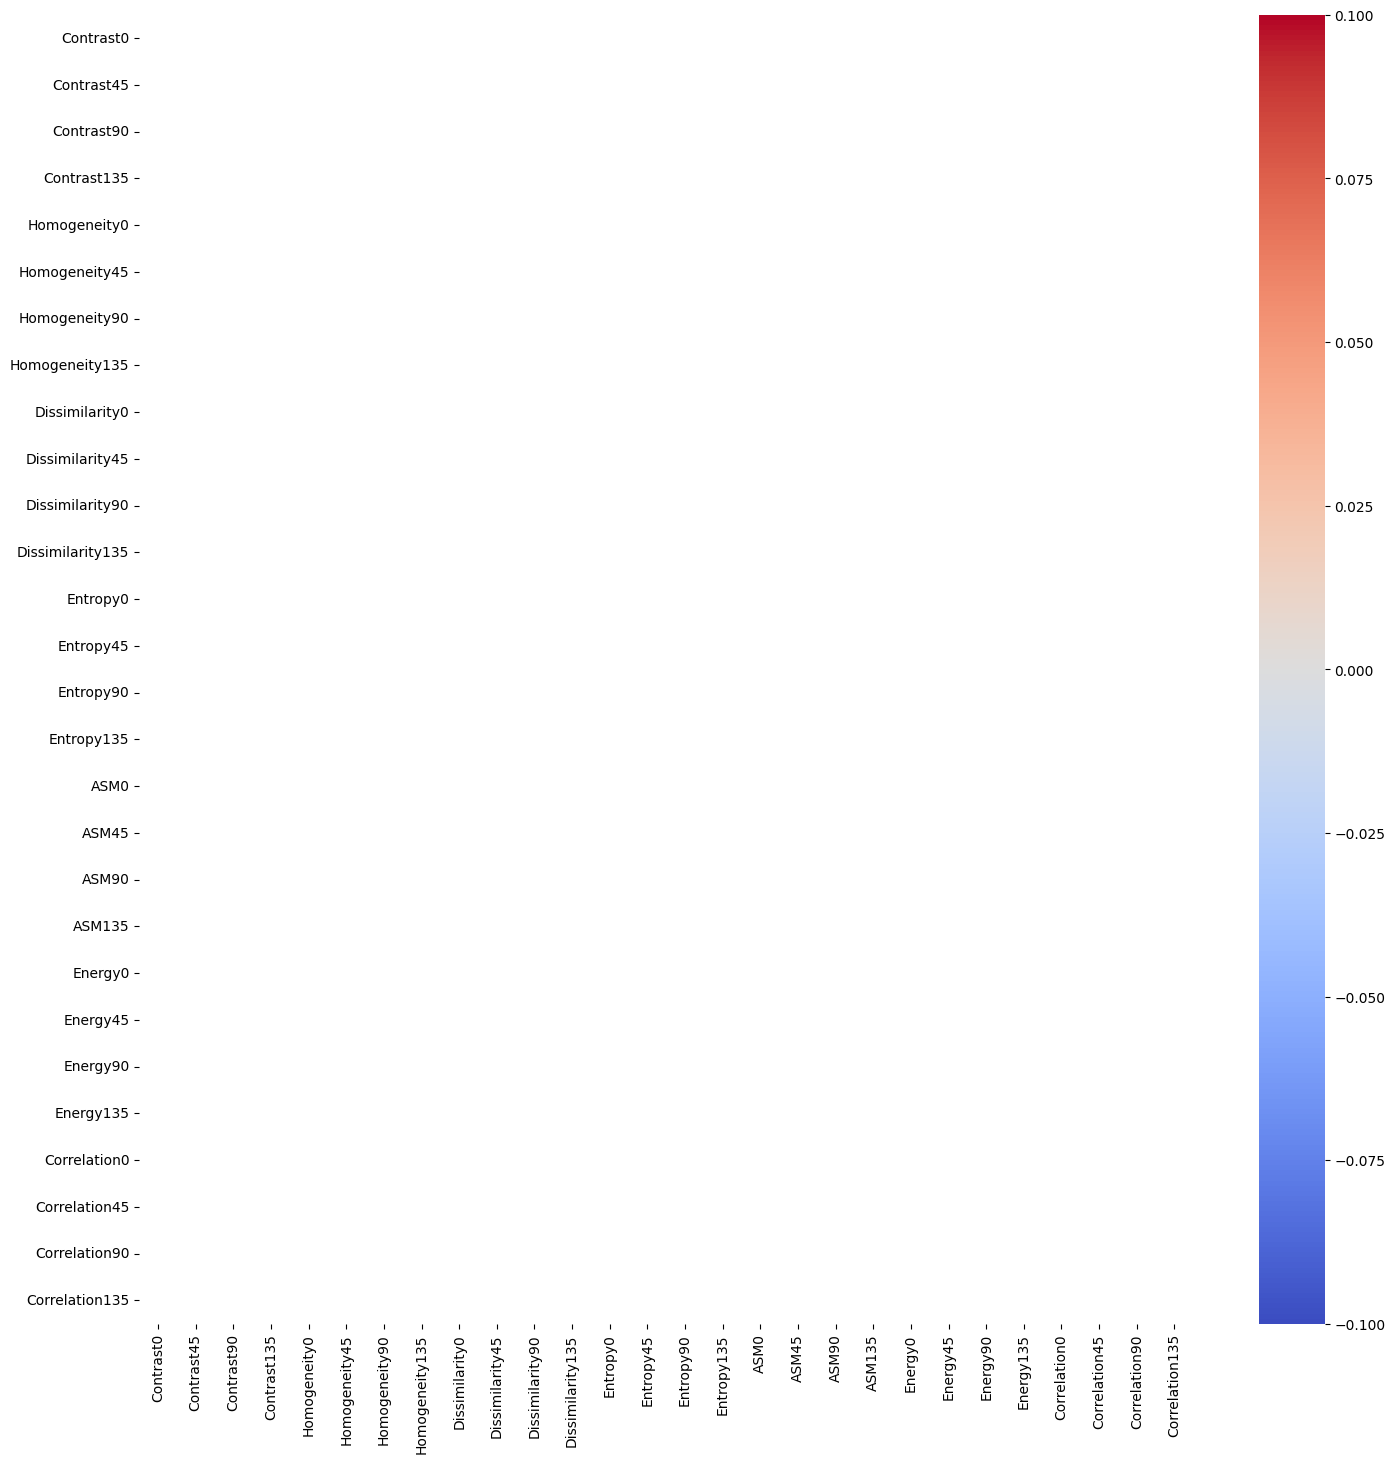

In [39]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [40]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(202, 28)
(51, 28)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [41]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [42]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [43]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.00      0.00      0.00        96
Impacted teeth       0.52      1.00      0.69       106

      accuracy                           0.52       202
     macro avg       0.26      0.50      0.34       202
  weighted avg       0.28      0.52      0.36       202

[[  0  96]
 [  0 106]]
Accuracy: 0.5247524752475248

------Testing Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.00      0.00      0.00        20
Impacted teeth       0.61      1.00      0.76        31

      accuracy                           0.61        51
     macro avg       0.30      0.50      0.38        51
  weighted avg       0.37      0.61      0.46        51

[[ 0 20]
 [ 0 31]]
Accuracy: 0.6078431372549019


C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

### Train SVM Classifier

In [44]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Train KNN Classifier

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                precision    recall  f1-score   support

        Caries       0.44      0.68      0.53        88
 Healthy Teeth       0.53      0.45      0.48        94
Impacted teeth       0.66      0.42      0.52        99

      accuracy                           0.51       281
     macro avg       0.54      0.52      0.51       281
  weighted avg       0.54      0.51      0.51       281

[[60 18 10]
 [40 42 12]
 [37 20 42]]
Accuracy: 0.5124555160142349

------Testing Set------
                precision    recall  f1-score   support

        Caries       0.44      0.35      0.39        31
 Healthy Teeth       0.23      0.32      0.26        22
Impacted teeth       0.33      0.28      0.30        18

      accuracy                           0.32        71
     macro avg       0.33      0.32      0.32        71
  weighted avg       0.35      0.32      0.33        71

[[11 15  5]
 [10  7  5]
 [ 4  9  5]]
Accuracy: 0.323943661971831


## Evaluation With Confusion Matrix

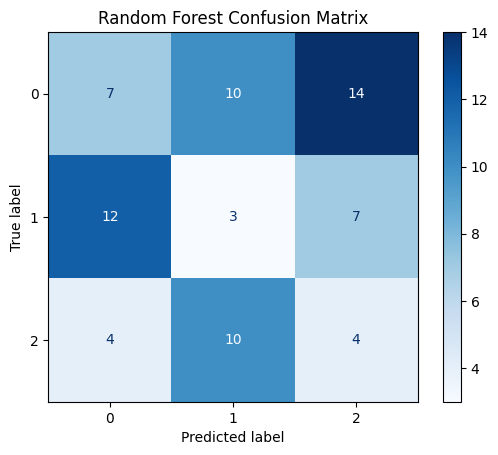

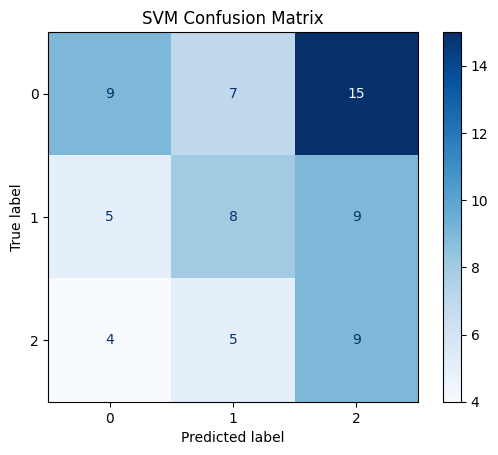

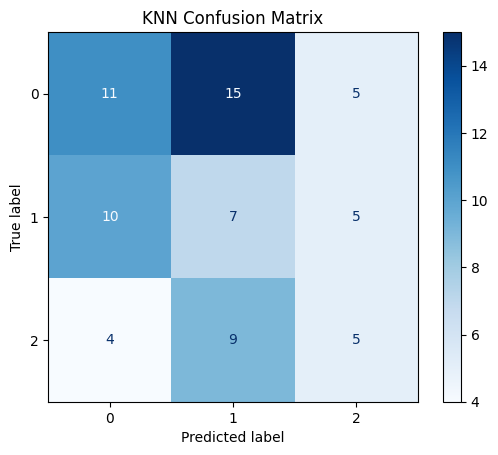

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")